In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
nltk.download('punkt')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Hareen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [56]:
# create column names
col_names = ['ID', 'Entity', 'Sentiment', 'Content']
# load the data
df = pd.read_csv('twitter_training.csv', names=col_names)
df.head()

,ID,Entity,Sentiment,Content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [58]:
# basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         74682 non-null  int64 
 1   Entity     74682 non-null  object
 2   Sentiment  74682 non-null  object
 3   Content    73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [60]:
# Check Data Dimensions
df.shape

(74682, 4)

In [62]:
df.dtypes

ID            int64
Entity       object
Sentiment    object
Content      object
dtype: object

## Data Preparation

In [65]:
# check for missing values
df.isnull().sum()

ID             0
Entity         0
Sentiment      0
Content      686
dtype: int64

##### Dealing with the missing values

In [68]:
# dropping the rows with content missing values
df.dropna(subset = ['Content'],inplace=True)

In [70]:
# Count the total number of duplicate rows
total_duplicates = df[df.duplicated(keep='first')].shape[0]

print("Total duplicate rows:", total_duplicates)

Total duplicate rows: 2340


Drop the duplicated rows

In [73]:
# Drop duplicate rows
df.drop_duplicates(keep='first', inplace=True)

# Reset the index after dropping duplicates
df.reset_index(drop=True, inplace=True)

replace irrelevant to neutral

In [76]:
# replace irrelevant to neutral
df['Sentiment'] = df['Sentiment'].replace('Irrelevant', 'Neutral')

## Exploratory Data Analysis

#### Sentiment distribution

In [80]:
df.Sentiment.unique()

array(['Positive', 'Neutral', 'Negative'], dtype=object)

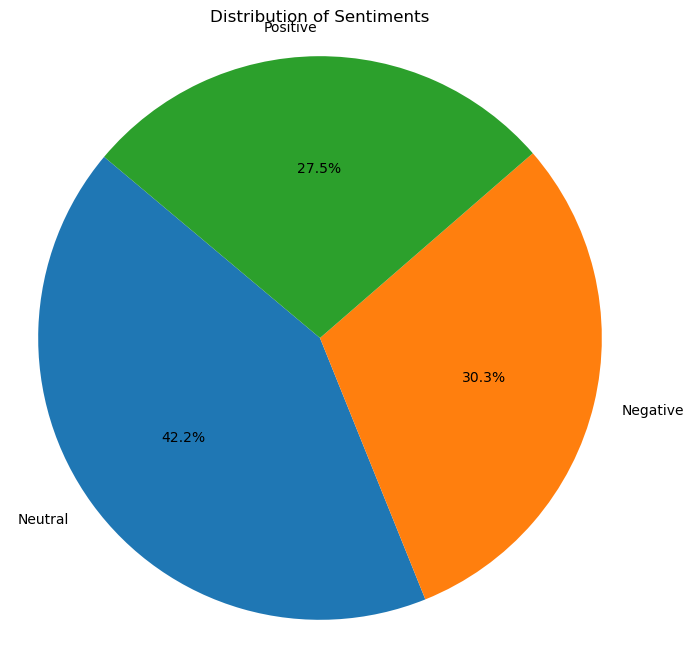

In [82]:
# Calculate the distribution of sentiments
sentiment_distribution = df['Sentiment'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_distribution, labels=sentiment_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Sentiments')
plt.axis('equal')  # Equal aspect ratio ensures that the pie chart is circular.

# Show the pie chart 42.2
plt.show()

#### Distribution of Entity

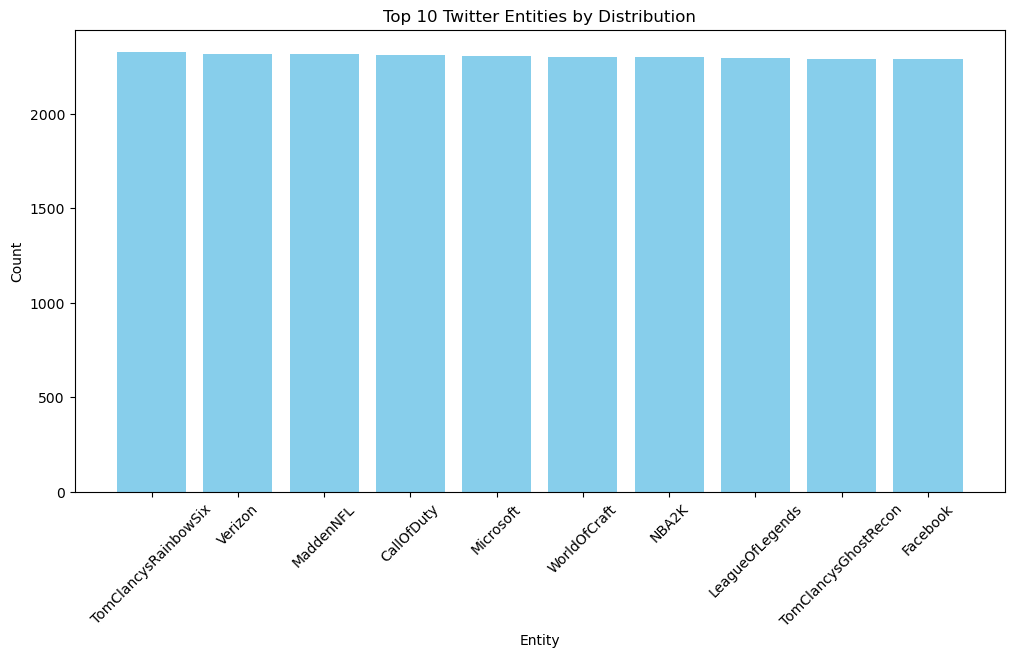

In [85]:
# Calculate the distribution of entities
entity_distribution = df['Entity'].value_counts()

# Select the top 10 entities
top_10_entities = entity_distribution.head(10)

# Create a bar chart for the top 10 entities
plt.figure(figsize=(12, 6))
plt.bar(top_10_entities.index, top_10_entities.values, color='skyblue')
plt.title('Top 10 Twitter Entities by Distribution')
plt.xlabel('Entity')
plt.ylabel('Count')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the bar chart
plt.show()

 The Top Entities 10 entity by distribution is TomClanysRainbow Six

#### Sentiment Distribution in Top 3 Entities

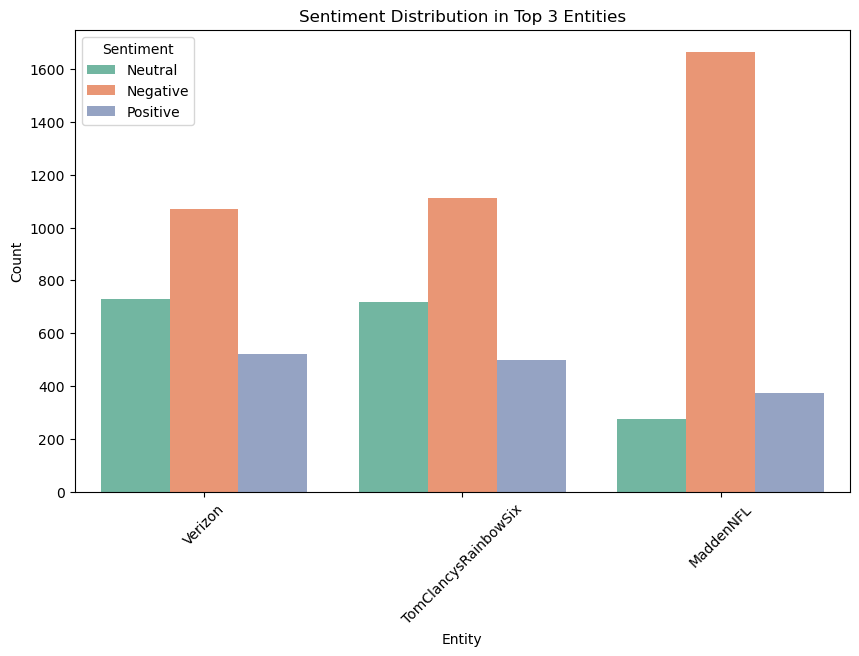

In [89]:
# Calculate the distribution of entities
entity_distribution = df['Entity'].value_counts()

# Select the top 3 entities
top_3_entities = entity_distribution.head(3).index

# Filter the DataFrame to include only the top 3 entities
df_top_3 = df[df['Entity'].isin(top_3_entities)]

# Create a grouped bar chart for sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df_top_3, x='Entity', hue='Sentiment', palette='Set2')
plt.title('Sentiment Distribution in Top 3 Entities')
plt.xlabel('Entity')
plt.ylabel('Count')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the grouped bar chart
plt.show()

Among the top 3 entities:

- **MaddenNFL:** It has the highest negative sentiment, indicating a notable amount of negative sentiment in conversations related to Madden NFL.
- **TomClancyRainbowSix:** Followed by Tom Clancy's Rainbow Six, which also experiences a significant negative sentiment.
- **Verizon:** Verizon has the highest neutral sentiment, suggesting a more balanced sentiment distribution.

Recommendations:
- **MaddenNFL and TomClancyRainbowSix:** Given the negative sentiment in these entities, consider addressing issues or concerns raised by users, improving customer experience, and actively engaging with the community to resolve complaints and improve brand perception.
- **Verizon:** Leverage the neutral sentiment by maintaining a consistent brand image and engaging with users to gather feedback and identify areas for improvement. Consider using the neutral sentiment as an opportunity to promote positive aspects of the brand.
These recommendations can help tailor strategies for each entity based on sentiment trends and user feedback.


#### Sentiment Distribution Analysis

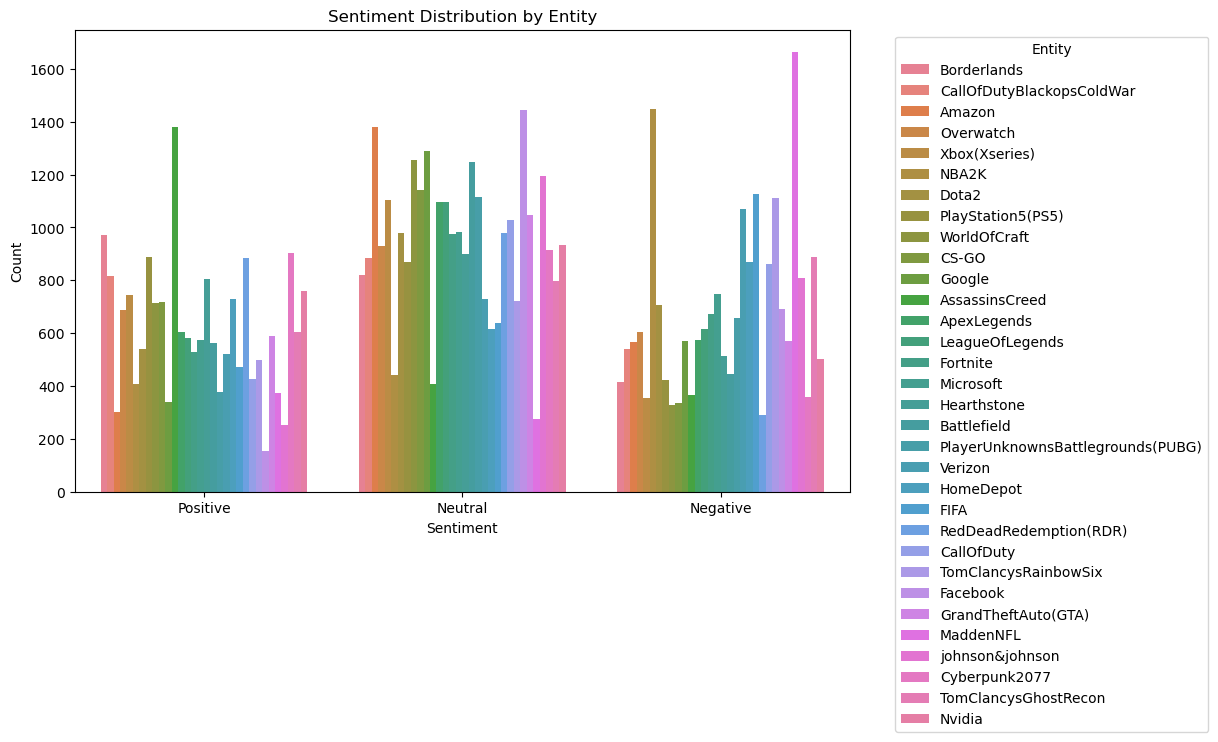

In [93]:
# Example for sentiment distribution by entity
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Sentiment', hue='Entity')
plt.title("Sentiment Distribution by Entity")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.legend(title='Entity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


### Sentiment Analysis

To perform sentiment analysis, I'll use the VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment analysis tool from NLTK. VADER is specifically designed for sentiment analysis of social media text

In [99]:
# loading vader to perform sentiment analysis
nltk.download('vader_lexicon')

# Initialize the sentiment analyzer without specifying the lexicon file
sia = SentimentIntensityAnalyzer()

# Function to get sentiment scores
def get_sentiment_scores(text):
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']

# Apply sentiment analysis to the 'Cleaned_Content' column
df['Sentiment_Score'] = df['Content'].apply(get_sentiment_scores)

# Categorize sentiment based on the compound score
def categorize_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment categorization
df['Sentiment_Predicted'] = df['Sentiment_Score'].apply(categorize_sentiment)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Hareen\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Distribution of predicted sentiments

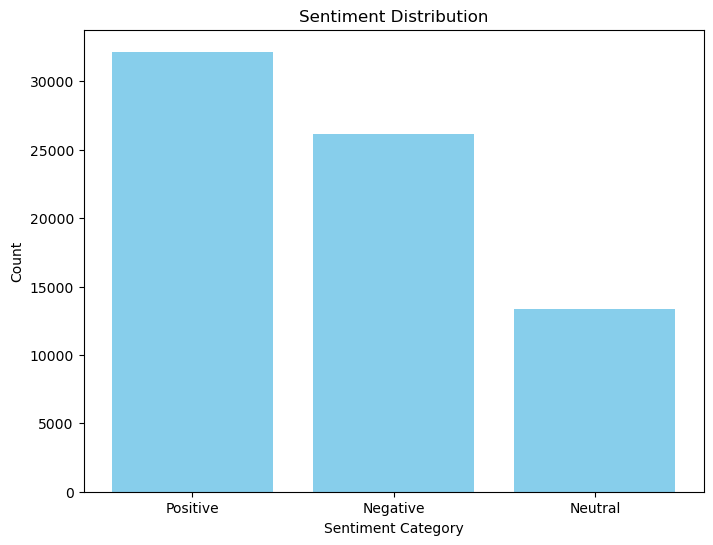

In [101]:
# lets Calculate the distribution of predicted sentiments
sentiment_distribution = df['Sentiment_Predicted'].value_counts()

# Create a bar chart for sentiment distribution
plt.figure(figsize=(8, 6))
plt.bar(sentiment_distribution.index, sentiment_distribution.values, color='skyblue')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')

# Show the bar chart
plt.show()


- **Sentiment Categories:** The bar chart illustrates the distribution of predicted sentiments within the social media content. Sentiments are categorized into three main categories: Positive, Negative, and Neutral.

- **Positive Sentiment Prevalence:** The most prevalent sentiment category is "Positive," indicating that a significant portion of the social media content expresses positive opinions or emotions. This suggests that users are actively sharing positive experiences, feedback, or sentiments related to various topics or entities.

- **User Engagement:** The distribution of sentiment categories reflects the diverse range of opinions and emotions expressed by users on social media platforms. Organizations should consider engaging with users across all sentiment categories to respond to feedback, address concerns, and build positive relationships.

- **Monitoring Sentiment Trends:** Regularly monitoring sentiment distribution can help organizations stay attuned to changes in public sentiment and adjust their strategies accordingly. An increase in negative sentiment, for example, may signal a need for issue resolution or improved communication.


#### Histogram of sentiment scores

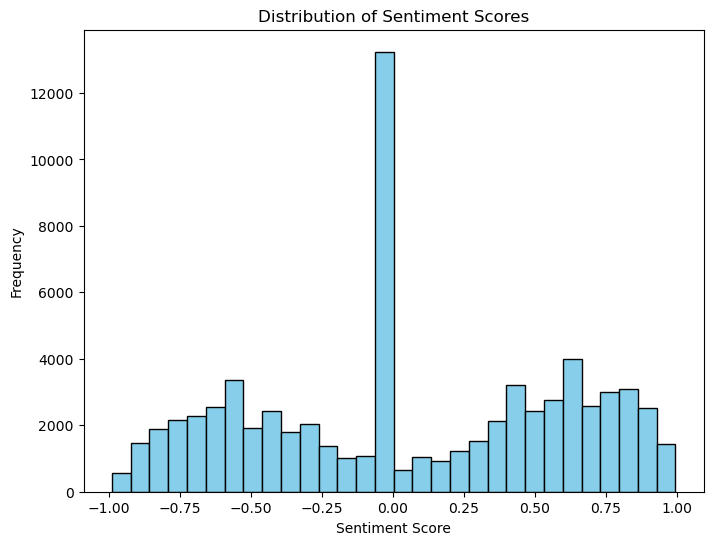

In [104]:
# Create a histogram of sentiment scores
plt.figure(figsize=(8, 6))
plt.hist(df['Sentiment_Score'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')

# Show the histogram
plt.show()

* Positive Sentiment Peak: A peak on the right side of the histogram corresponds to sentiment scores greater than 0, indicating positive sentiments. This suggests that a significant portion of the text data expresses positive sentiments.
* Negative Sentiment Peak: Another peak on the left side of the histogram represents sentiment scores less than 0, signifying negative sentiments. This indicates the presence of text data expressing negative sentiments.
* Neutral Sentiment: The central area of the histogram, around the score of 0, corresponds to neutral sentiments. It shows that a considerable volume of text data is neutral in nature.

#### Word Cloud for Positive Sentiment

word cloud for text associated with positive sentiment

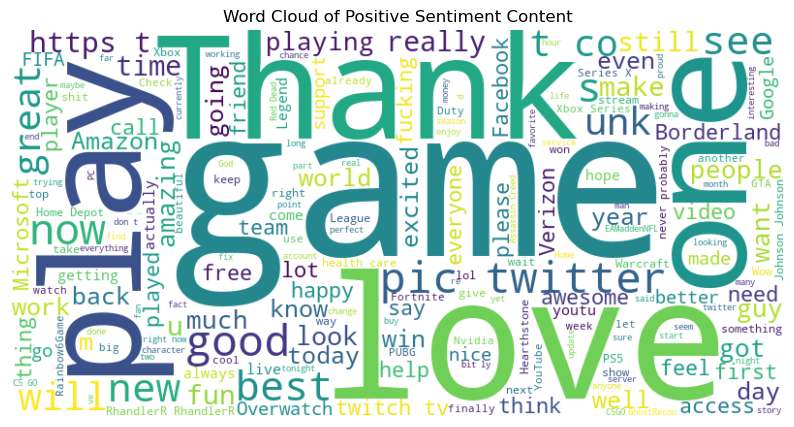

In [119]:
# Filter data for positive sentiment
positive_data = df[df['Sentiment_Predicted'] == 'Positive']

# Combine all lemmatized text for positive sentiment
positive_text_data = ' '.join(positive_data['Content'].dropna())

# Generate a word cloud for positive sentiment
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text_data)

# Display the word cloud for positive sentiment
plt.figure(figsize=(10, 6))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Positive Sentiment Content")
plt.show()


#### Word Cloud for Negative Sentiment  
Generate a word cloud for text associated with negative sentiment.

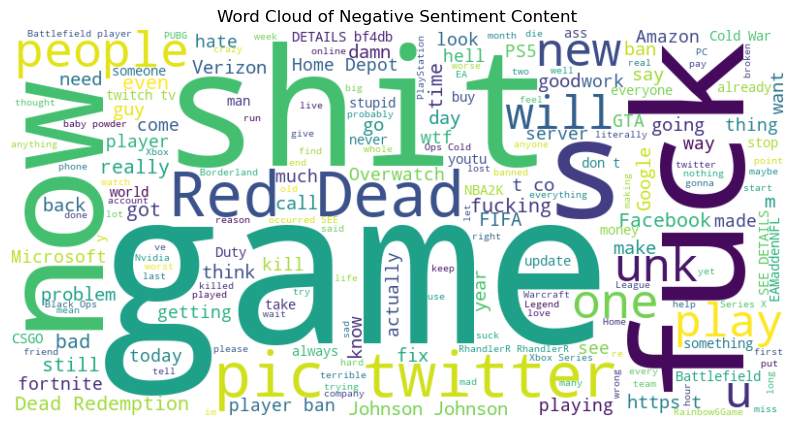

In [124]:
# lets Filter data for negative sentiment
negative_data = df[df['Sentiment_Predicted'] == 'Negative']

# Combine all lemmatized text for negative sentiment
negative_text_data = ' '.join(negative_data['Content'].dropna())

# Generate a word cloud for negative sentiment
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text_data)

# Display the word cloud for negative sentiment
plt.figure(figsize=(10, 6))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Negative Sentiment Content")
plt.show()


#### Word Cloud for Neutral Sentiment

a word cloud for text associated with neutral sentiment

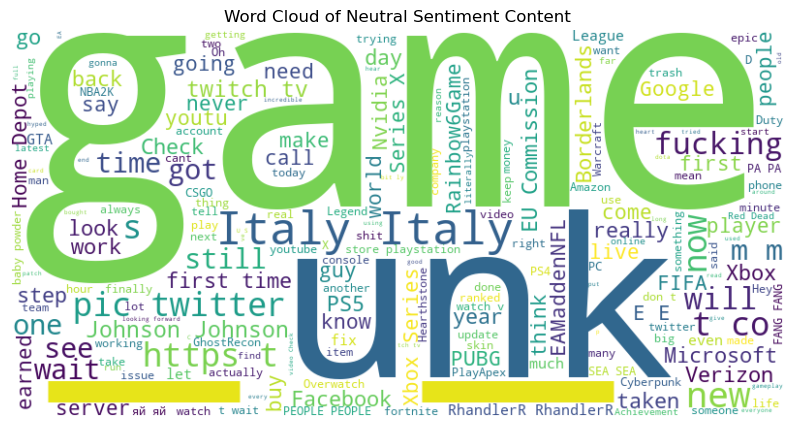

In [130]:
# lets Filter data for neutral sentiment
neutral_data = df[df['Sentiment_Predicted'] == 'Neutral']

# Combine all lemmatized text for neutral sentiment
neutral_text_data = ' '.join(neutral_data['Content'].dropna())

# Generate a word cloud for neutral sentiment
neutral_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(neutral_text_data)

# Display the word cloud for neutral sentiment
plt.figure(figsize=(10, 6))
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Neutral Sentiment Content")
plt.show()
